<a href="https://colab.research.google.com/github/Priscille-Erulin/Import-Colab/blob/main/PART1_PJT_GRAPSING_ERULIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FONCTIONS UTILES**

In [ ]:
## Trace les rectangles de grasping sur une image
def draw_rectangle(mes_rectangles, image):
  '''
  mes_rectangles est une liste de liste contenant les 4 points d'un rectangle
  image est un numpy array sur lequel on va tracer les rectangles de grasping
  '''
  # passe un par un les rectangles de la liste de rectange et prend les 4 coordonnées
  for rectangle in mes_rectangles:                      
      point1, point2 = tuple([int(float(point)) for point in rectangle[0]]), tuple(
          [int(float(point)) for point in rectangle[1]])                                      
      point3, point4 = tuple([int(float(point)) for point in rectangle[2]]), tuple(
          [int(float(point)) for point in rectangle[3]])
      cv2.line(image, point1, point2, color=(0, 0, 255), thickness=1)
      cv2.line(image, point3, point4, color=(0, 0, 255), thickness=1)
      cv2.line(image, point2, point3, color=(0, 255, 0), thickness=2)
      cv2.line(image, point4, point1, color=(0, 255, 0), thickness=2)
  return image


def vizualise(x, y):
  '''
  x : est une image brute
  y : est une liste de liste contenant les paramètres de grasping # parametres à donner au robot

  meme si vous voulez visualiser qu'un seul paramètre de grasping, y doit être une liste de liste.
  '''
  tot_rect = []
  for box in y:
    if box[0]<500:
      rect = grasp_to_bbox(box)     #les tranforme en coordonnées du rectangle
      rect = [float(item) for vertex in rect for item in vertex]
      grasp = bboxes_to_grasps(rect)
      new_rect = grasp_to_bbox(grasp)
      tot_rect.append(new_rect)
  image = draw_rectangle(tot_rect, x)
  plt.imshow(image)
  plt.imshow(x)
  plt.title('grasping rectangles')


def bboxes_to_grasps(box):
  '''
  Converti les représentations rectangle en paramètres de grasping
  '''
  x = (box[0] + (box[4] - box[0])/2)
  y = (box[1] + (box[5] - box[1])/2)
  if box[0] == box[2]:
      tan = 30
  else:
      tan = -(box[3] - box[1]) / (box[2] - box[0])
  tan = max(-11, min(tan, 11))
  w = np.sqrt(np.power((box[2] - box[0]), 2) + np.power((box[3] - box[1]), 2))
  h = np.sqrt(np.power((box[6] - box[0]), 2) + np.power((box[7] - box[1]), 2))
  angle = np.arctan(tan) * 180/np.pi
  return x, y, angle, h, w


def grasp_to_bbox(grasp):
  '''
  Converti les paramètres de grasping en représentations rectangle
  '''
  x, y, theta, h, w = tuple(grasp)
  theta = theta * np.pi/180
  edge1 = [x - w/2*np.cos(theta) + h/2*np.sin(theta), y + w/2*np.sin(theta) + h/2*np.cos(theta)]
  edge2 = [x + w/2*np.cos(theta) + h/2*np.sin(theta), y - w/2*np.sin(theta) + h/2*np.cos(theta)]
  edge3 = [x + w/2*np.cos(theta) - h/2*np.sin(theta), y - w/2*np.sin(theta) - h/2*np.cos(theta)]
  edge4 = [x - w/2*np.cos(theta) - h/2*np.sin(theta), y + w/2*np.sin(theta) - h/2*np.cos(theta)]
  return [edge1, edge2, edge3, edge4]


from shapely.geometry import Polygon

def performance(Y_pred, Y_true):
  '''
  Y_pred et Y_true sont tous les deux des paramètres de grasping 
  '''
  grasp_pred = grasp_to_bbox(Y_pred)
  grasp_true = grasp_to_bbox(Y_true)

  p_pred = Polygon(grasp_pred)
  p_true = Polygon(grasp_true)

  iou = p_pred.intersection(p_true).area / (p_pred.area + p_true.area - p_pred.intersection(p_true).area)
  theta_pred, theta_true = Y_pred[2], Y_true[2]
  if iou > 0.25 and (np.abs(theta_pred-theta_true) < 30 or np.abs(theta_pred % 180-theta_true % 180)):
      return True
  else:
      return False

**IMPORTATION DES DONNÉES**

In [ ]:
#données du prof
! rm -r process_Cornell
! git clone https://github.com/LaurentBimont/process_Cornell


rm: cannot remove 'process_Cornell': No such file or directory
Cloning into 'process_Cornell'...
remote: Enumerating objects: 146, done.
remote: Total 146 (delta 0), reused 0 (delta 0), pack-reused 146
Receiving objects: 100% (146/146), 112.18 MiB | 27.92 MiB/s, done.
Resolving deltas: 100% (31/31), done.


**IMPORTATION DES BIBLIOTHEQUES**

In [ ]:

%tensorflow_version 2.x magic #installation du dernier tensorflow possible en version 2, "magic" n'est que dispo sur collab
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
import os 
import cv2


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


**CRÉATION DES ARRAYS DE DONNÉES** 

In [ ]:
X = []
folder_name = 'process_Cornell/x_split/'
for file_num in range(len(os.listdir(folder_name))):
  X.extend(np.load(folder_name + 'x_{}.npy'.format(file_num)))

X = np.array(X)
Y = np.load('process_Cornell/all_Y_test_format.npy', allow_pickle=True)
Y = np.array([np.array(y) for y in Y])

# X est un array de 750 images de taille 224*224 codé en RVB
# Y est un array de 750 array contenant chacun un certain nombre d'array (le nombre de grasp possible par image) a 5 composants (les caracteristiques de chaque grasp) 




**SÉPARATION DES DONNÉES EN TEST ET TRAIN**

De maniere aleatoire, le test size permet de diviser le groupe de données en deux selon les proposrtions 2/3, 1/3

On obtient deux ensembles de 500 et 250 images

In [ ]:
X1, Y1 = np.copy(X), np.copy(Y)


from sklearn.model_selection import train_test_split

#on sépare les données en 2/3, 1/3

X_train, X_test, Y_train1, Y_test1 = train_test_split(X, Y,test_size=0.333)
 
#on commence par ne récuperer qu'un seul grasping par image

Y_train=np.array([[0,0,0,0,0]]*len(Y_train1))
Y_test=np.array([[0,0,0,0,0]]*len(Y_test1))

for k in range(len(Y_train1)):
  Y_train[k]=np.array(Y_train1[k][1])

for k in range(len(Y_test1)):
  Y_test[k]=np.array(Y_test1[k][1])

#vérification dee la répartition
print (len(X_train), len(X_test), len(Y_train),len(Y_test))

500 250 500 250


**ARCHTECTURE ET FONCTION DE PERTE**

Le probleme rencontré est de type régréssion, nous allons donc utiliser ue fonction de perte de type: mean squared error

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Input, Dense, Dropout, BatchNormalization, Flatten, MaxPooling2D


def model_1():
  

  model = Sequential()
  
  model.add(Conv2D(filters=39, kernel_size=(3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
 
  #X_train.shape[1:]= (224, 224, 3), indique les dimensions de l'image d'entré du filtre
  #on peux jouer sur le nombre de filtre mais trop = redondances
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())    #liste de liste devient liste
  model.add(Dense(units=350, activation='relu'))
  model.add(Dense(units=350, activation='relu'))
  model.add(Dense(units=350, activation='relu'))
  model.add(Dense(units=350, activation='relu'))
  model.add(Dense(5,activation='linear'))   #le nombre d'units est 5 car c'est le nombre de données d'un grasping qui est l info que l'on veux en sortie
  # ajout de cinq couches de neuronnes : les 4 premieres à 350 neuronnes, la derniere à 5
  #pour une fonction de regression, l'activation peut etre relu ou linear, ici linear sur le dernier neuronne a un meilleur loss 
 

  opt= tf.keras.optimizers.Adam(learning_rate=0.01) #pas d'évolution

  model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=['accuracy'])
  
  history1 = model.fit(X_train,Y_train, batch_size=20, epochs=10, validation_data=(X_test, Y_test)) #overfitting pour 10 itérations (très accurate sur le train et pas sur le test)

  plt.plot(history1.history['loss'], marker='o', label='training loss')
  plt.plot(history1.history['val_loss'], marker='o', label='validation loss')
  plt.xlabel('Number of epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.ylim(0,1000) #le premier loss écrase toute la courbe sinon
#voir la convergence du modèle
  
  
  # permet d'obtenir les 
  model.evaluate(X_test, Y_test)
  return model


**SAUVEGARDE DE L'ENTRAINEMENT**

Epoch 1/10
25/25 [==============================] - 16s 623ms/step - loss: 1268700544.0000 - accuracy: 0.4740 - val_loss: 880.2180 - val_accuracy: 0.6800
Epoch 2/10
25/25 [==============================] - 15s 621ms/step - loss: 2245.0383 - accuracy: 0.5140 - val_loss: 1399.7976 - val_accuracy: 0.6800
Epoch 3/10
25/25 [==============================] - 15s 590ms/step - loss: 1075.4098 - accuracy: 0.6980 - val_loss: 825.4706 - val_accuracy: 0.6800
Epoch 4/10
25/25 [==============================] - 15s 587ms/step - loss: 882.3431 - accuracy: 0.6980 - val_loss: 808.7311 - val_accuracy: 0.6800
Epoch 5/10
25/25 [==============================] - 15s 590ms/step - loss: 894.7361 - accuracy: 0.6980 - val_loss: 831.9280 - val_accuracy: 0.6800
Epoch 6/10
25/25 [==============================] - 15s 589ms/step - loss: 898.5217 - accuracy: 0.6980 - val_loss: 797.2355 - val_accuracy: 0.6800
Epoch 7/10
25/25 [==============================] - 15s 586ms/step - loss: 876.6696 - accuracy: 0.6980 - val

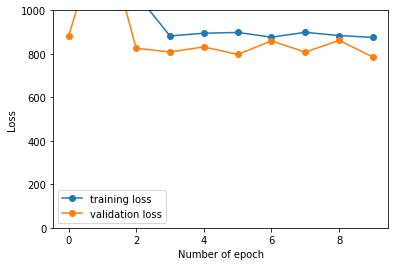

In [ ]:
model1=model_1()

#model1.save_weights('model_1.h5')



#model1.load_weights('model_1.h5')


**PERFORMANCE**

In [ ]:
def test_performance(y_pred, y_test):
  n=y_pred.shape[0]
  count=0
  for k in range (n):
    pred=y_pred[k]
    im=0
    for i in range (len(y_test[k])):
      im=0                                   #compte le nombre le nombre de graspings proches de la prediction par image
      if performance(pred,y_test[k][i]):
        im+=1
    if im!=0:                               #verifie si la prediction sur l'image k est valable pour au moins 1 des solutions possibles
      count+=1
        
  return count/n





In [ ]:
### Test
y_pred = model1.predict(X_test)
print('Performance de mon modèle entraîné : {:.1%}'.format(test_performance(y_pred, Y_test1)))
#performance moyenne de ce modèle pouvant etre améliorée en utilisant toutes les données de grasping disponible par image par ex

Performance de mon modèle entraîné : 24.0%


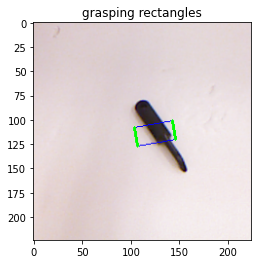

In [ ]:
def show_prediction(model, x):
  y=model.predict(x)
  
  vizualise(x[0],[y[0]])           #affiche la premiere image 

#test
show_prediction(model1,X_train)